<a href="https://colab.research.google.com/github/raghumriyer/colab/blob/master/Generative_Adversarial_Network_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network.

GAN generative adversarial network

In [0]:
#!pip install Pillow
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import SGD
from os import environ
import argparse
import tarfile
import os
import threading
import shutil
import zipfile
from itertools import cycle
import multiprocessing as mp
import numpy as np
from keras.utils.data_utils import get_file
import pytest
import six
from six.moves.urllib.parse import urljoin
from six.moves.urllib.request import pathname2url
from six.moves import reload_module
import matplotlib.pyplot as plt
from PIL import Image



In [20]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#orig_dir = "/content/drive/My Drive/UTKface_inthewild"
orig_dir = "/content/drive/My Drive/EIP3/Face/data"
dest_dir = "/content/drive/My Drive/EIP3/Face/data"
txt_dest_dir = "/content/drive/My Drive/EIP3/Face/data"

if(not os.path.exists(dest_dir)):
  tar_file_path = os.path.join(orig_dir, 'UTKFace.tar.gz')
  origin = urljoin('file://', pathname2url(os.path.abspath(tar_file_path)))
  path = get_file('UTKFace1.tar.gz', origin, untar=True, cache_subdir=dest_dir)
  
if( not os.path.exists(dest_dir)):
  tar_file_path = os.path.join(orig_dir, 'part1.tar.gz')
  origin = urljoin('file://', pathname2url(os.path.abspath(tar_file_path)))
  path = get_file('part1.tar.gz', origin, untar=True, cache_subdir=dest_dir)
  
  
  tar_file_path = os.path.join(orig_dir, 'part2.tar.gz')
  origin = urljoin('file://', pathname2url(os.path.abspath(tar_file_path)))
  path = get_file('part2.tar.gz', origin, untar=True, cache_subdir=dest_dir)
  
  
  tar_file_path = os.path.join(orig_dir, 'part3.tar.gz')
  origin = urljoin('file://', pathname2url(os.path.abspath(tar_file_path)))
  path = get_file('part3.tar.gz', origin, untar=True, cache_subdir=dest_dir)
  
  #text_file_path = os.path.join(dest_dir, 'test.txt.tar.gz')
  #txt_origin = urljoin('file://', pathname2url(os.path.abspath(text_file_path)))
  #path = get_file('test.txt', txt_origin, untar=True, cache_subdir=txt_dest_dir)

#hashval_sha256 = keras.utils.data_utils._hash_file(filepath)
#hashval_md5 = keras.utils.data_utils._hash_file(filepath, algorithm='md5')

#path = keras.utils.data_utils.get_file('test.txt', origin, md5_hash=hashval_md5,untar=True, cache_subdir=dest_dir)
#path = keras.utils.data_utils.get_file(filepath, origin, file_hash=hashval_sha256,extract=True, cache_subdir=dest_dir)
  

In [22]:
!pip install Pillow
!pip install scipy==1.1.0
from __future__ import division
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize, imsave


def conv2d(input_map, num_output_channels, size_kernel=5, stride=2, name='conv2d'):
    with tf.variable_scope(name):
        # stddev = np.sqrt(2.0 / (np.sqrt(input_map.get_shape()[-1].value * num_output_channels) * size_kernel ** 2))
        stddev = .02
        kernel = tf.get_variable(
            name='w',
            shape=[size_kernel, size_kernel, input_map.get_shape()[-1], num_output_channels],
            dtype=tf.float32,
            initializer=tf.truncated_normal_initializer(stddev=stddev)
        )
        biases = tf.get_variable(
            name='b',
            shape=[num_output_channels],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0)
        )
        conv = tf.nn.conv2d(input_map, kernel, strides=[1, stride, stride, 1], padding='SAME')
        return tf.nn.bias_add(conv, biases)


def fc(input_vector, num_output_length, name='fc'):
    with tf.variable_scope(name):
        # stddev = np.sqrt(1.0 / (np.sqrt(input_vector.get_shape()[-1].value * num_output_length)))
        stddev = .02
        w = tf.get_variable(
            name='w',
            shape=[input_vector.get_shape()[1], num_output_length],
            dtype=tf.float32,
            initializer=tf.random_normal_initializer(stddev=stddev)
        )
        b = tf.get_variable(
            name='b',
            shape=[num_output_length],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0)
        )
        return tf.matmul(input_vector, w) + b


def deconv2d(input_map, output_shape, size_kernel=5, stride=2, stddev=0.02, name='deconv2d'):
    with tf.variable_scope(name):
        # stddev = np.sqrt(1.0 / (np.sqrt(input_map.get_shape()[-1].value * output_shape[-1]) * size_kernel ** 2))
        stddev = .02
        # filter : [height, width, output_channels, in_channels]
        kernel = tf.get_variable(
            name='w',
            shape=[size_kernel, size_kernel, output_shape[-1], input_map.get_shape()[-1]],
            dtype=tf.float32,
            initializer=tf.random_normal_initializer(stddev=stddev)
        )
        biases = tf.get_variable(
            name='b',
            shape=[output_shape[-1]],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0)
        )
        deconv = tf.nn.conv2d_transpose(input_map, kernel, strides=[1, stride, stride, 1], output_shape=output_shape)
        return tf.nn.bias_add(deconv, biases)
       

def lrelu(logits, leak=0.2):
    return tf.maximum(logits, leak*logits)


def concat_label(x, label, duplicate=1):
    x_shape = x.get_shape().as_list()
    if duplicate < 1:
        return x
    # duplicate the label to enhance its effect, does it really affect the result?
    label = tf.tile(label, [1, duplicate])
    label_shape = label.get_shape().as_list()
    if len(x_shape) == 2:
        return tf.concat(axis=1, values=[x, label])
    elif len(x_shape) == 4:
        label = tf.reshape(label, [x_shape[0], 1, 1, label_shape[-1]])
        return tf.concat(axis=3, values=[x, label*tf.ones([x_shape[0], x_shape[1], x_shape[2], label_shape[-1]])])


def load_image(
        image_path,  # path of a image
        image_size=64,  # expected size of the image
        image_value_range=(-1, 1),  # expected pixel value range of the image
        is_gray=False,  # gray scale or color image
):
    if is_gray:
        image = imread(image_path, mode='L').astype(np.float32)
    else:
        image = imread(image_path, mode='RGB').astype(np.float32)
    image = imresize(image, [image_size, image_size])
    image = image.astype(np.float32) * (image_value_range[-1] - image_value_range[0]) / 255.0 + image_value_range[0]
    return image


def save_batch_images(
        batch_images,   # a batch of images
        save_path,  # path to save the images
        image_value_range=(-1,1),   # value range of the input batch images
        size_frame=None     # size of the image matrix, number of images in each row and column
):
    # transform the pixcel value to 0~1
    images = (batch_images - image_value_range[0]) / (image_value_range[-1] - image_value_range[0])
    if size_frame is None:
        auto_size = int(np.ceil(np.sqrt(images.shape[0])))
        size_frame = [auto_size, auto_size]
    img_h, img_w = batch_images.shape[1], batch_images.shape[2]
    frame = np.zeros([img_h * size_frame[0], img_w * size_frame[1], 3])
    for ind, image in enumerate(images):
        ind_col = ind % size_frame[1]
        ind_row = ind // size_frame[1]
        frame[(ind_row * img_h):(ind_row * img_h + img_h), (ind_col * img_w):(ind_col * img_w + img_w), :] = image
    imsave(save_path, frame)


In [0]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
import numpy as np
from scipy.io import savemat
#from ops import *
from tensorflow.python.framework import ops
from tensorflow.python.framework.ops import *


class FaceAging(object):
    def __init__(self,
                 session,  # TensorFlow session
                 size_image=128,  # size the input images
                 size_kernel=5,  # size of the kernels in convolution and deconvolution
                 size_batch=100,  # mini-batch size for training and testing, must be square of an integer
                 num_input_channels=3,  # number of channels of input images
                 num_encoder_channels=64,  # number of channels of the first conv layer of encoder
                 num_z_channels=50,  # number of channels of the layer z (noise or code)
                 num_categories=10,  # number of categories (age segments) in the training dataset
                 num_gen_channels=1024,  # number of channels of the first deconv layer of generator
                 enable_tile_label=True,  # enable to tile the label
                 tile_ratio=1.0,  # ratio of the length between tiled label and z
                 is_training=True,  # flag for training or testing mode
                 save_dir='/content/drive/My Drive/EIP3/Face/data/save',  # path to save checkpoints, samples, and summary
                 dataset_name='UTKFace'  # name of the dataset in the folder ./data
                 #dataset_name=''  # name of the dataset in the folder ./data
                 ):

        self.session = session
        self.image_value_range = (-1, 1)
        self.size_image = size_image
        self.size_kernel = size_kernel
        self.size_batch = size_batch
        self.num_input_channels = num_input_channels
        self.num_encoder_channels = num_encoder_channels
        self.num_z_channels = num_z_channels
        self.num_categories = num_categories
        self.num_gen_channels = num_gen_channels
        self.enable_tile_label = enable_tile_label
        self.tile_ratio = tile_ratio
        self.is_training = is_training
        self.save_dir = save_dir
        self.dataset_name = dataset_name

        # ************************************* input to graph ********************************************************
        self.input_image = tf.placeholder(
            tf.float32,
            [self.size_batch, self.size_image, self.size_image, self.num_input_channels],
            name='input_images'
        )
        self.age = tf.placeholder(
            tf.float32,
            [self.size_batch, self.num_categories],
            name='age_labels'
        )
        self.gender = tf.placeholder(
            tf.float32,
            [self.size_batch, 2],
            name='gender_labels'
        )
        self.z_prior = tf.placeholder(
            tf.float32,
            [self.size_batch, self.num_z_channels],
            name='z_prior'
        )
        # ************************************* build the graph *******************************************************
        print('\n\tBuilding graph ...')

        # encoder: input image --> z
        self.z = self.encoder(
            image=self.input_image
        )
        print('\n\tBuilding graph11 ...')
        # generator: z + label --> generated image
        self.G = self.generator(
            z=self.z,
            y=self.age,
            gender=self.gender,
            enable_tile_label=self.enable_tile_label,
            tile_ratio=self.tile_ratio
        )
        print('\n\tBuilding graph1 ...')
        # discriminator on z
        self.D_z, self.D_z_logits = self.discriminator_z(
            z=self.z,
            is_training=self.is_training
        )

        # discriminator on G
        self.D_G, self.D_G_logits = self.discriminator_img(
            image=self.G,
            y=self.age,
            gender=self.gender,
            is_training=self.is_training
        )

        # discriminator on z_prior
        self.D_z_prior, self.D_z_prior_logits = self.discriminator_z(
            z=self.z_prior,
            is_training=self.is_training,
            reuse_variables=True
        )
        print('\n\tBuilding graph2 ...')
        # discriminator on input image
        self.D_input, self.D_input_logits = self.discriminator_img(
            image=self.input_image,
            y=self.age,
            gender=self.gender,
            is_training=self.is_training,
            reuse_variables=True
        )

        # ************************************* loss functions *******************************************************
        # loss function of encoder + generator
        #self.EG_loss = tf.nn.l2_loss(self.input_image - self.G) / self.size_batch  # L2 loss
        self.EG_loss = tf.reduce_mean(tf.abs(self.input_image - self.G))  # L1 loss

        # loss function of discriminator on z
        self.D_z_loss_prior = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_z_prior_logits, labels=tf.ones_like(self.D_z_prior_logits))
        )
        self.D_z_loss_z = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_z_logits, labels=tf.zeros_like(self.D_z_logits))
        )
        self.E_z_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_z_logits, labels=tf.ones_like(self.D_z_logits))
        )
        # loss function of discriminator on image
        self.D_img_loss_input = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_input_logits, labels=tf.ones_like(self.D_input_logits))
        )
        self.D_img_loss_G = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_G_logits, labels=tf.zeros_like(self.D_G_logits))
        )
        self.G_img_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_G_logits, labels=tf.ones_like(self.D_G_logits))
        )

        # total variation to smooth the generated image
        tv_y_size = self.size_image
        tv_x_size = self.size_image
        self.tv_loss = (
            (tf.nn.l2_loss(self.G[:, 1:, :, :] - self.G[:, :self.size_image - 1, :, :]) / tv_y_size) +
            (tf.nn.l2_loss(self.G[:, :, 1:, :] - self.G[:, :, :self.size_image - 1, :]) / tv_x_size)) / self.size_batch

        # *********************************** trainable variables ****************************************************
        trainable_variables = tf.trainable_variables()
        # variables of encoder
        self.E_variables = [var for var in trainable_variables if 'E_' in var.name]
        # variables of generator
        self.G_variables = [var for var in trainable_variables if 'G_' in var.name]
        # variables of discriminator on z
        self.D_z_variables = [var for var in trainable_variables if 'D_z_' in var.name]
        # variables of discriminator on image
        self.D_img_variables = [var for var in trainable_variables if 'D_img_' in var.name]

        # ************************************* collect the summary ***************************************
        self.z_summary = tf.summary.histogram('z', self.z)
        self.z_prior_summary = tf.summary.histogram('z_prior', self.z_prior)
        self.EG_loss_summary = tf.summary.scalar('EG_loss', self.EG_loss)
        self.D_z_loss_z_summary = tf.summary.scalar('D_z_loss_z', self.D_z_loss_z)
        self.D_z_loss_prior_summary = tf.summary.scalar('D_z_loss_prior', self.D_z_loss_prior)
        self.E_z_loss_summary = tf.summary.scalar('E_z_loss', self.E_z_loss)
        self.D_z_logits_summary = tf.summary.histogram('D_z_logits', self.D_z_logits)
        self.D_z_prior_logits_summary = tf.summary.histogram('D_z_prior_logits', self.D_z_prior_logits)
        self.D_img_loss_input_summary = tf.summary.scalar('D_img_loss_input', self.D_img_loss_input)
        self.D_img_loss_G_summary = tf.summary.scalar('D_img_loss_G', self.D_img_loss_G)
        self.G_img_loss_summary = tf.summary.scalar('G_img_loss', self.G_img_loss)
        self.D_G_logits_summary = tf.summary.histogram('D_G_logits', self.D_G_logits)
        self.D_input_logits_summary = tf.summary.histogram('D_input_logits', self.D_input_logits)
        # for saving the graph and variables
        self.saver = tf.train.Saver(max_to_keep=2)

    def train(self,
              num_epochs=200,  # number of epochs
              learning_rate=0.0002,  # learning rate of optimizer
              beta1=0.5,  # parameter for Adam optimizer
              decay_rate=1.0,  # learning rate decay (0, 1], 1 means no decay
              enable_shuffle=True,  # enable shuffle of the dataset
              use_trained_model=True,  # use the saved checkpoint to initialize the network
              use_init_model=True,  # use the init model to initialize the network
              weigts=(0.0001, 0, 0)  # the weights of adversarial loss and TV loss
              ):

        # *************************** load file names of images ******************************************************
        print("Calling the train model")
        #filename = os.path.abspath("/content/drive/My Drive/EIP3/"+file)
        
        #"https://drive.google.com/open?id=0BxYys69jI14kYVM3aVhKS1VhRUk",
        #dest_dir
        dest_dir1 = "/content/drive/My Drive/EIP3/Face/data/"
        
        #file_names = glob(os.path.join(dest_dir1, '*.jpg'))
        file_names = glob(os.path.join(dest_dir1, self.dataset_name, '*.jpg'))
        size_data = len(file_names)
        print("The dest =",dest_dir1)
        print("The len of files in ",file_names)#,len(file_names))
        print("The len of files in ",len(file_names))
        np.random.seed(seed=2017)
        if enable_shuffle:
            np.random.shuffle(file_names)

        # *********************************** optimizer **************************************************************
        # over all, there are three loss functions, weights may differ from the paper because of different datasets
        self.loss_EG = self.EG_loss + weigts[0] * self.G_img_loss + weigts[1] * self.E_z_loss + weigts[2] * self.tv_loss # slightly increase the params
        self.loss_Dz = self.D_z_loss_prior + self.D_z_loss_z
        self.loss_Di = self.D_img_loss_input + self.D_img_loss_G

        # set learning rate decay
        self.EG_global_step = tf.Variable(0, trainable=False, name='global_step')
        EG_learning_rate = tf.train.exponential_decay(
            learning_rate=learning_rate,
            global_step=self.EG_global_step,
            decay_steps=size_data / self.size_batch * 2,
            decay_rate=decay_rate,
            staircase=True
        )

        # optimizer for encoder + generator
        with tf.variable_scope('opt', reuse=tf.AUTO_REUSE):
            self.EG_optimizer = tf.train.AdamOptimizer(
                learning_rate=EG_learning_rate,
                beta1=beta1
            ).minimize(
                loss=self.loss_EG,
                global_step=self.EG_global_step,
                var_list=self.E_variables + self.G_variables
            )

            # optimizer for discriminator on z
            self.D_z_optimizer = tf.train.AdamOptimizer(
                learning_rate=EG_learning_rate,
                beta1=beta1
            ).minimize(
                loss=self.loss_Dz,
                var_list=self.D_z_variables
            )

            # optimizer for discriminator on image
            self.D_img_optimizer = tf.train.AdamOptimizer(
                learning_rate=EG_learning_rate,
                beta1=beta1
            ).minimize(
                loss=self.loss_Di,
                var_list=self.D_img_variables
            )

        # *********************************** tensorboard *************************************************************
        # for visualization (TensorBoard): $ tensorboard --logdir path/to/log-directory
        self.EG_learning_rate_summary = tf.summary.scalar('EG_learning_rate', EG_learning_rate)
        self.summary = tf.summary.merge([
            self.z_summary, self.z_prior_summary,
            self.D_z_loss_z_summary, self.D_z_loss_prior_summary,
            self.D_z_logits_summary, self.D_z_prior_logits_summary,
            self.EG_loss_summary, self.E_z_loss_summary,
            self.D_img_loss_input_summary, self.D_img_loss_G_summary,
            self.G_img_loss_summary, self.EG_learning_rate_summary,
            self.D_G_logits_summary, self.D_input_logits_summary
        ])
        self.writer = tf.summary.FileWriter(os.path.join(self.save_dir, 'summary'), self.session.graph)

        # ************* get some random samples as testing data to visualize the learning process *********************
        sample_files = file_names[0:self.size_batch]
        file_names[0:self.size_batch] = []
        sample = [load_image(
            image_path=sample_file,
            image_size=self.size_image,
            image_value_range=self.image_value_range,
            is_gray=(self.num_input_channels == 1),
        ) for sample_file in sample_files]
        if self.num_input_channels == 1:
            sample_images = np.array(sample).astype(np.float32)[:, :, :, None]
        else:
            sample_images = np.array(sample).astype(np.float32)
        sample_label_age = np.ones(
            shape=(len(sample_files), self.num_categories),
            dtype=np.float32
        ) * self.image_value_range[0]
        sample_label_gender = np.ones(
            shape=(len(sample_files), 2),
            dtype=np.float32
        ) * self.image_value_range[0]
        for i, label in enumerate(sample_files):
            label = int(str(sample_files[i]).split('/')[-1].split('_')[0])
            if 0 <= label <= 5:
                label = 0
            elif 6 <= label <= 10:
                label = 1
            elif 11 <= label <= 15:
                label = 2
            elif 16 <= label <= 20:
                label = 3
            elif 21 <= label <= 30:
                label = 4
            elif 31 <= label <= 40:
                label = 5
            elif 41 <= label <= 50:
                label = 6
            elif 51 <= label <= 60:
                label = 7
            elif 61 <= label <= 70:
                label = 8
            else:
                label = 9
            sample_label_age[i, label] = self.image_value_range[-1]
            gender = int(str(sample_files[i]).split('/')[-1].split('_')[1])
            sample_label_gender[i, gender] = self.image_value_range[-1]

        # ******************************************* training *******************************************************
        # initialize the graph
        tf.global_variables_initializer().run()

        # load check point
        if use_trained_model:
            if self.load_checkpoint():
                print("\tSUCCESS ^_^")
            else:
                print("\tFAILED >_<!")
                # load init model
                if use_init_model:
                    if not os.path.exists('init_model/model-init.data-00000-of-00001'):
                        from init_model.zip_opt import join
                        try:
                            join('init_model/model_parts', 'init_model/model-init.data-00000-of-00001')
                        except:
                            raise Exception('Error joining files')
                    self.load_checkpoint(model_path='init_model')


        # epoch iteration
        num_batches = len(file_names) // self.size_batch
        for epoch in range(num_epochs):
            if enable_shuffle:
                np.random.shuffle(file_names)
            for ind_batch in range(num_batches):
                start_time = time.time()
                # read batch images and labels
                batch_files = file_names[ind_batch*self.size_batch:(ind_batch+1)*self.size_batch]
                batch = [load_image(
                    image_path=batch_file,
                    image_size=self.size_image,
                    image_value_range=self.image_value_range,
                    is_gray=(self.num_input_channels == 1),
                ) for batch_file in batch_files]
                if self.num_input_channels == 1:
                    batch_images = np.array(batch).astype(np.float32)[:, :, :, None]
                else:
                    batch_images = np.array(batch).astype(np.float32)
                batch_label_age = np.ones(
                    shape=(len(batch_files), self.num_categories),
                    dtype=np.float
                ) * self.image_value_range[0]
                batch_label_gender = np.ones(
                    shape=(len(batch_files), 2),
                    dtype=np.float
                ) * self.image_value_range[0]
                for i, label in enumerate(batch_files):
                    label = int(str(batch_files[i]).split('/')[-1].split('_')[0])
                    if 0 <= label <= 5:
                        label = 0
                    elif 6 <= label <= 10:
                        label = 1
                    elif 11 <= label <= 15:
                        label = 2
                    elif 16 <= label <= 20:
                        label = 3
                    elif 21 <= label <= 30:
                        label = 4
                    elif 31 <= label <= 40:
                        label = 5
                    elif 41 <= label <= 50:
                        label = 6
                    elif 51 <= label <= 60:
                        label = 7
                    elif 61 <= label <= 70:
                        label = 8
                    else:
                        label = 9
                    batch_label_age[i, label] = self.image_value_range[-1]
                    gender = int(str(batch_files[i]).split('/')[-1].split('_')[1])
                    batch_label_gender[i, gender] = self.image_value_range[-1]

                # prior distribution on the prior of z
                batch_z_prior = np.random.uniform(
                    self.image_value_range[0],
                    self.image_value_range[-1],
                    [self.size_batch, self.num_z_channels]
                ).astype(np.float32)

                # update
                _, _, _, EG_err, Ez_err, Dz_err, Dzp_err, Gi_err, DiG_err, Di_err, TV = self.session.run(
                    fetches = [
                        self.EG_optimizer,
                        self.D_z_optimizer,
                        self.D_img_optimizer,
                        self.EG_loss,
                        self.E_z_loss,
                        self.D_z_loss_z,
                        self.D_z_loss_prior,
                        self.G_img_loss,
                        self.D_img_loss_G,
                        self.D_img_loss_input,
                        self.tv_loss
                    ],
                    feed_dict={
                        self.input_image: batch_images,
                        self.age: batch_label_age,
                        self.gender: batch_label_gender,
                        self.z_prior: batch_z_prior
                    }
                )

                print("\nEpoch: [%3d/%3d] Batch: [%3d/%3d]\n\tEG_err=%.4f\tTV=%.4f" %
                    (epoch+1, num_epochs, ind_batch+1, num_batches, EG_err, TV))
                print("\tEz=%.4f\tDz=%.4f\tDzp=%.4f" % (Ez_err, Dz_err, Dzp_err))
                print("\tGi=%.4f\tDi=%.4f\tDiG=%.4f" % (Gi_err, Di_err, DiG_err))

                # estimate left run time
                elapse = time.time() - start_time
                time_left = ((num_epochs - epoch - 1) * num_batches + (num_batches - ind_batch - 1)) * elapse
                print("\tTime left: %02d:%02d:%02d" %
                      (int(time_left / 3600), int(time_left % 3600 / 60), time_left % 60))

                # add to summary
                summary = self.summary.eval(
                    feed_dict={
                        self.input_image: batch_images,
                        self.age: batch_label_age,
                        self.gender: batch_label_gender,
                        self.z_prior: batch_z_prior
                    }
                )
                self.writer.add_summary(summary, self.EG_global_step.eval())

            # save sample images for each epoch
            name = '{:02d}.png'.format(epoch+1)
            self.sample(sample_images, sample_label_age, sample_label_gender, name)
            self.test(sample_images, sample_label_gender, name)

            # save checkpoint for each 5 epoch
            if np.mod(epoch, 5) == 4:
                self.save_checkpoint()

        # save the trained model
        self.save_checkpoint()
        # close the summary writer
        self.writer.close()


    def encoder(self, image, reuse_variables=False):
        if reuse_variables:
            tf.get_variable_scope().reuse_variables()
        num_layers = int(np.log2(self.size_image)) - int(self.size_kernel / 2)
        #print("Calling from the encoder")
        current = image
        # conv layers with stride 2
        for i in range(num_layers):
            name = 'E_conv' + str(i)
            #print("Calling from the encoder1.2")
            current = conv2d(
                    input_map=current,
                    num_output_channels=self.num_encoder_channels * (2 ** i),
                    #filters=self.num_encoder_channels * (2 ** i),
                    size_kernel=self.size_kernel,
                    name=name
                )
            #print("Calling from the encoder1.3")
            current = tf.nn.relu(current)
        #print("Calling from the encoder1")
        # fully connection layer
        name = 'E_fc'
        current = fc(
            input_vector=tf.reshape(current, [self.size_batch, -1]),
            num_output_length=self.num_z_channels,
            name=name
        )
        #print("Calling from the encoder3")
        # output
        return tf.nn.tanh(current)

    def generator(self, z, y, gender, reuse_variables=False, enable_tile_label=True, tile_ratio=1.0):
        if reuse_variables:
            tf.get_variable_scope().reuse_variables()
        num_layers = int(np.log2(self.size_image)) - int(self.size_kernel / 2)
        if enable_tile_label:
            duplicate = int(self.num_z_channels * tile_ratio / self.num_categories)
        else:
            duplicate = 1
        z = concat_label(z, y, duplicate=duplicate)
        if enable_tile_label:
            duplicate = int(self.num_z_channels * tile_ratio / 2)
        else:
            duplicate = 1
        z = concat_label(z, gender, duplicate=duplicate)
        size_mini_map = int(self.size_image / 2 ** num_layers)
        # fc layer
        name = 'G_fc'
        current = fc(
            input_vector=z,
            num_output_length=self.num_gen_channels * size_mini_map * size_mini_map,
            name=name
        )
        # reshape to cube for deconv
        current = tf.reshape(current, [-1, size_mini_map, size_mini_map, self.num_gen_channels])
        current = tf.nn.relu(current)
        # deconv layers with stride 2
        for i in range(num_layers):
            name = 'G_deconv' + str(i)
            current = deconv2d(
                    input_map=current,
                    output_shape=[self.size_batch,
                                  size_mini_map * 2 ** (i + 1),
                                  size_mini_map * 2 ** (i + 1),
                                  int(self.num_gen_channels / 2 ** (i + 1))],
                    size_kernel=self.size_kernel,
                    name=name
                )
            current = tf.nn.relu(current)
        name = 'G_deconv' + str(i+1)
        current = deconv2d(
            input_map=current,
            output_shape=[self.size_batch,
                          self.size_image,
                          self.size_image,
                          int(self.num_gen_channels / 2 ** (i + 2))],
            size_kernel=self.size_kernel,
            stride=1,
            name=name
        )
        current = tf.nn.relu(current)
        name = 'G_deconv' + str(i + 2)
        current = deconv2d(
            input_map=current,
            output_shape=[self.size_batch,
                          self.size_image,
                          self.size_image,
                          self.num_input_channels],
            size_kernel=self.size_kernel,
            stride=1,
            name=name
        )

        # output
        return tf.nn.tanh(current)

    def discriminator_z(self, z, is_training=True, reuse_variables=False, num_hidden_layer_channels=(64, 32, 16), enable_bn=True):
        if reuse_variables:
            tf.get_variable_scope().reuse_variables()
        current = z
        # fully connection layer
        for i in range(len(num_hidden_layer_channels)):
            name = 'D_z_fc' + str(i)
            current = fc(
                    input_vector=current,
                    num_output_length=num_hidden_layer_channels[i],
                    name=name
                )
            if enable_bn:
                name = 'D_z_bn' + str(i)
                current = tf.contrib.layers.batch_norm(
                    current,
                    scale=False,
                    is_training=is_training,
                    scope=name,
                    reuse=reuse_variables
                )
            current = tf.nn.relu(current)
        # output layer
        name = 'D_z_fc' + str(i+1)
        current = fc(
            input_vector=current,
            num_output_length=1,
            name=name
        )
        return tf.nn.sigmoid(current), current

    def discriminator_img(self, image, y, gender, is_training=True, reuse_variables=False, num_hidden_layer_channels=(16, 32, 64, 128), enable_bn=True):
        if reuse_variables:
            tf.get_variable_scope().reuse_variables()
        num_layers = len(num_hidden_layer_channels)
        current = image
        # conv layers with stride 2
        for i in range(num_layers):
            name = 'D_img_conv' + str(i)
            current = conv2d(
                    input_map=current,
                    num_output_channels=num_hidden_layer_channels[i],
                    size_kernel=self.size_kernel,
                    name=name
                )
            if enable_bn:
                name = 'D_img_bn' + str(i)
                current = tf.contrib.layers.batch_norm(
                    current,
                    scale=False,
                    is_training=is_training,
                    scope=name,
                    reuse=reuse_variables
                )
            current = tf.nn.relu(current)
            if i == 0:
                current = concat_label(current, y)
                current = concat_label(current, gender, int(self.num_categories / 2))
        # fully connection layer
        name = 'D_img_fc1'
        current = fc(
            input_vector=tf.reshape(current, [self.size_batch, -1]),
            num_output_length=1024,
            name=name
        )
        current = lrelu(current)
        name = 'D_img_fc2'
        current = fc(
            input_vector=current,
            num_output_length=1,
            name=name
        )
        # output
        return tf.nn.sigmoid(current), current

    def save_checkpoint(self):
        checkpoint_dir = os.path.join(self.save_dir, 'checkpoint')
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        self.saver.save(
            sess=self.session,
            save_path=os.path.join(checkpoint_dir, 'model'),
            global_step=self.EG_global_step.eval()
        )

    def load_checkpoint(self, model_path=None):
        if model_path is None:
            print("\n\tLoading pre-trained model from...",self.save_dir)
            checkpoint_dir = os.path.join(self.save_dir, 'checkpoint')
        else:
            print("\n\tLoading init model ...")
            checkpoint_dir = model_path
        checkpoints = tf.train.get_checkpoint_state(checkpoint_dir)
        if checkpoints and checkpoints.model_checkpoint_path:
            checkpoints_name = os.path.basename(checkpoints.model_checkpoint_path)
            print("The checkpoint name=",checkpoints_name)
            print("The checkpoint dir name=",checkpoint_dir)
            try:
                self.saver.restore(self.session, os.path.join(checkpoint_dir, checkpoints_name))
                return True
            except:
                return False
        else:
            return False

    def sample(self, images, labels, gender, name):
        sample_dir = os.path.join(self.save_dir, 'samples')
        if not os.path.exists(sample_dir):
            os.makedirs(sample_dir)
        z, G = self.session.run(
            [self.z, self.G],
            feed_dict={
                self.input_image: images,
                self.age: labels,
                self.gender: gender
            }
        )
        size_frame = int(np.sqrt(self.size_batch))
        save_batch_images(
            batch_images=G,
            save_path=os.path.join(sample_dir, name),
            image_value_range=self.image_value_range,
            size_frame=[size_frame, size_frame]
        )

    def test(self, images, gender, name):
        test_dir = os.path.join(self.save_dir, 'test')
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        images = images[:int(np.sqrt(self.size_batch)), :, :, :]
        gender = gender[:int(np.sqrt(self.size_batch)), :]
        size_sample = images.shape[0]
        labels = np.arange(size_sample)
        labels = np.repeat(labels, size_sample)
        query_labels = np.ones(
            shape=(size_sample ** 2, size_sample),
            dtype=np.float32
        ) * self.image_value_range[0]
        for i in range(query_labels.shape[0]):
            query_labels[i, labels[i]] = self.image_value_range[-1]
        query_images = np.tile(images, [self.num_categories, 1, 1, 1])
        query_gender = np.tile(gender, [self.num_categories, 1])
        z, G = self.session.run(
            [self.z, self.G],
            feed_dict={
                self.input_image: query_images,
                self.age: query_labels,
                self.gender: query_gender
            }
        )
        save_batch_images(
            batch_images=query_images,
            save_path=os.path.join(test_dir, 'input.png'),
            image_value_range=self.image_value_range,
            size_frame=[size_sample, size_sample]
        )
        save_batch_images(
            batch_images=G,
            save_path=os.path.join(test_dir, name),
            image_value_range=self.image_value_range,
            size_frame=[size_sample, size_sample]
        )

    def custom_test(self, testing_samples_dir):
        if not self.load_checkpoint():
            print("\tFAILED >_<!")
            exit(0)
        else:
            print("\tSUCCESS ^_^")

        num_samples = int(np.sqrt(self.size_batch))
        print("the  testing dir=",testing_samples_dir)
        file_names = glob(testing_samples_dir)
        print("The file names",file_names)
        if len(file_names) < num_samples:
            print ('The number of testing images is must larger than %d' % num_samples)
            exit(0)
        sample_files = file_names[0:num_samples]
        sample = [load_image(
            image_path=sample_file,
            image_size=self.size_image,
            image_value_range=self.image_value_range,
            is_gray=(self.num_input_channels == 1),
        ) for sample_file in sample_files]
        if self.num_input_channels == 1:
            images = np.array(sample).astype(np.float32)[:, :, :, None]
        else:
            images = np.array(sample).astype(np.float32)
        gender_male = np.ones(
            shape=(num_samples, 2),
            dtype=np.float32
        ) * self.image_value_range[0]
        gender_female = np.ones(
            shape=(num_samples, 2),
            dtype=np.float32
        ) * self.image_value_range[0]
        for i in range(gender_male.shape[0]):
            gender_male[i, 0] = self.image_value_range[-1]
            gender_female[i, 1] = self.image_value_range[-1]

        self.test(images, gender_male, 'test_as_male.png')
        self.test(images, gender_female, 'test_as_female.png')
        
        im = os.path.join(self.save_dir, 'test', 'test_as_male.png')
        pil_im = Image.open(im) #Take jpg + png
        ## Uncomment to open from URL
        #import requests
        #r = requests.get('https://www.vegvesen.no/public/webkamera/kamera?id=131206')
        #pil_im = Image.open(BytesIO(r.content))
        im_array = np.asarray(pil_im)
        plt.imshow(im_array)
        plt.show()
        
        im = os.path.join(self.save_dir, 'test', 'test_as_female.png')
        pil_im = Image.open(im) #Take jpg + png
        ## Uncomment to open from URL
        #import requests
        #r = requests.get('https://www.vegvesen.no/public/webkamera/kamera?id=131206')
        #pil_im = Image.open(BytesIO(r.content))
        im_array = np.asarray(pil_im)
        plt.imshow(im_array)
        plt.show()
        
        print ('\n\tDone! Results are saved as %s\n' % os.path.join(self.save_dir, 'test', 'test_as_xxx.png'))

In [0]:
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [0]:
from easydict import EasyDict as easydict
import easydict
#parser = argparse.ArgumentParser(description='CAAE')
#parser.add_argument('--is_train', type=str2bool, default=True)
#parser.add_argument('--epoch', type=int, default=50, help='number of epochs')
#parser.add_argument('--dataset', type=str, default='UTKFace', help='training dataset name that stored in ./data')
#parser.add_argument('--savedir', type=str, default='save', help='dir of saving checkpoints and intermediate training results')
#parser.add_argument('--testdir', type=str, default='None', help='dir of testing images')
#parser.add_argument('--use_trained_model', type=str2bool, default=True, help='whether train from an existing model or from scratch')
#parser.add_argument('--use_init_model', type=str2bool, default=True, help='whether train from the init model if cannot find an existing model')
#FLAGS = parser.parse_args()

#FLAGS = parser.parse_args(argv[1:])
FLAGS = easydict.EasyDict({
    "is_train":False,   
    "epoch":50,
    "dataset":'UTKFace',
    "savedir":'/content/drive/My Drive/EIP3/Face/data/save',
    "testdir":'/content/drive/My Drive/EIP3/Face/data/save/test',
    "use_trained_model":True,
    "use_init_model":False,
    "batch_size": 100,    
    "train_steps": 1000
})


In [0]:





def main(_):

    # print settings
    import pprint
    pprint.pprint(FLAGS)

    config = tf.ConfigProto()
    print(config)
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as session:
        model = FaceAging(
            session,  # TensorFlow session
            is_training=FLAGS.is_train,  # flag for training or testing mode
            save_dir=FLAGS.savedir,  # path to save checkpoints, samples, and summary
            dataset_name=FLAGS.dataset  # name of the dataset in the folder ./data
        )
        print("save dir=",FLAGS.savedir)
        if FLAGS.is_train:
            print ('\n\tTraining Mode')
            if not FLAGS.use_trained_model:
                print ('\n\tPre-train the network')
                model.train(
                    num_epochs=10,  # number of epochs
                    use_trained_model=FLAGS.use_trained_model,
                    use_init_model=FLAGS.use_init_model,
                    weigts=(0, 0, 0)
                )
                print ('\n\tPre-train is done! The training will start.')
            model.train(
                num_epochs=FLAGS.epoch,  # number of epochs
                use_trained_model=FLAGS.use_trained_model,
                use_init_model=FLAGS.use_init_model
            )
            print ('\n\tPre-train is done! The training will start.')
        else:
            print ('\n\tTesting Mode')
            model.custom_test(
                testing_samples_dir=FLAGS.testdir + '/*.png'
            )




{'batch_size': 100,
 'dataset': 'UTKFace',
 'epoch': 50,
 'is_train': False,
 'savedir': '/content/drive/My Drive/EIP3/Face/data/save',
 'testdir': '/content/drive/My Drive/EIP3/Face/data/save/test',
 'train_steps': 1000,
 'use_init_model': False,
 'use_trained_model': True}


	Building graph ...

	Building graph11 ...

	Building graph1 ...


I0801 22:22:26.179826 140609049278336 saver.py:1280] Restoring parameters from /content/drive/My Drive/EIP3/Face/data/save/checkpoint/model-11800



	Building graph2 ...
save dir= /content/drive/My Drive/EIP3/Face/data/save

	Testing Mode

	Loading pre-trained model from... /content/drive/My Drive/EIP3/Face/data/save
The checkpoint name= model-11800
The checkpoint dir name= /content/drive/My Drive/EIP3/Face/data/save/checkpoint
	SUCCESS ^_^
the  testing dir= /content/drive/My Drive/EIP3/Face/data/save/test/*.png
The file names ['/content/drive/My Drive/EIP3/Face/data/save/test/01.png', '/content/drive/My Drive/EIP3/Face/data/save/test/02.png', '/content/drive/My Drive/EIP3/Face/data/save/test/03.png', '/content/drive/My Drive/EIP3/Face/data/save/test/04.png', '/content/drive/My Drive/EIP3/Face/data/save/test/05.png', '/content/drive/My Drive/EIP3/Face/data/save/test/06.png', '/content/drive/My Drive/EIP3/Face/data/save/test/07.png', '/content/drive/My Drive/EIP3/Face/data/save/test/08.png', '/content/drive/My Drive/EIP3/Face/data/save/test/09.png', '/content/drive/My Drive/EIP3/Face/data/save/test/10.png', '/content/drive/My Drive

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


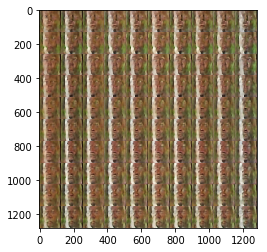

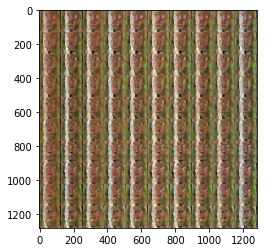


	Done! Results are saved as /content/drive/My Drive/EIP3/Face/data/save/test/test_as_xxx.png



SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [27]:
if __name__ == '__main__':
    # with tf.device('/cpu:0'):
    tf.app.run(main=None,argv=None)